In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

from utilities2015 import *

from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import average, fcluster, single, complete

from joblib import Parallel, delayed

from skimage.color import gray2rgb
from skimage.measure import find_contours
from skimage.util import img_as_float

import matplotlib.pyplot as plt
%matplotlib inline

from networkx import from_dict_of_lists, Graph, adjacency_matrix, connected_components
from networkx.algorithms import node_connected_component, dfs_successors, dfs_postorder_nodes

from itertools import product

from scipy.spatial.distance import pdist

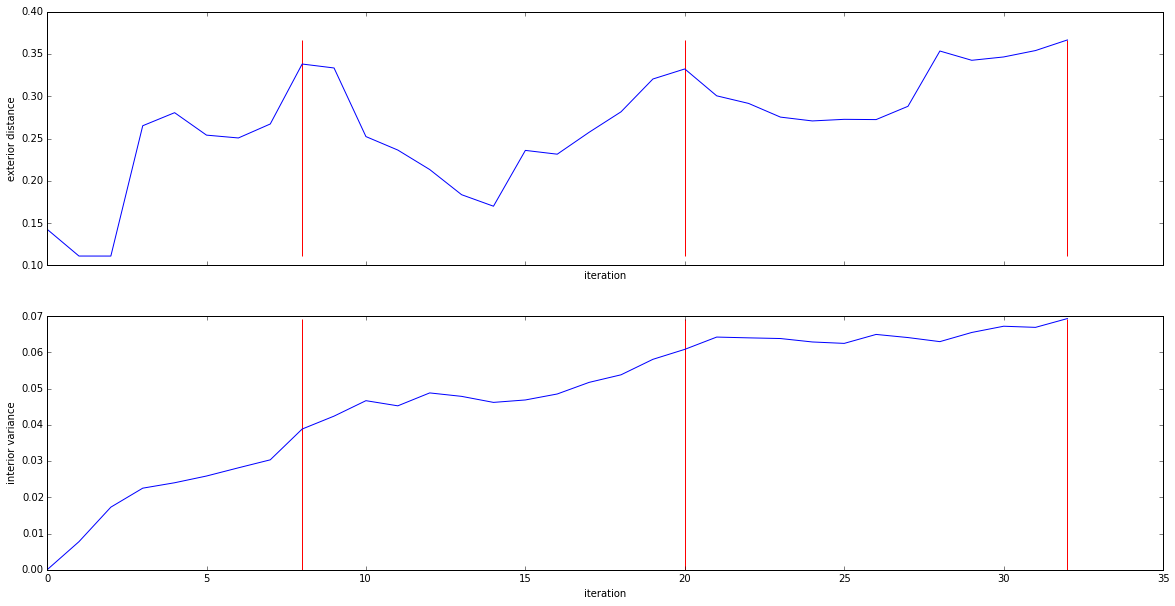

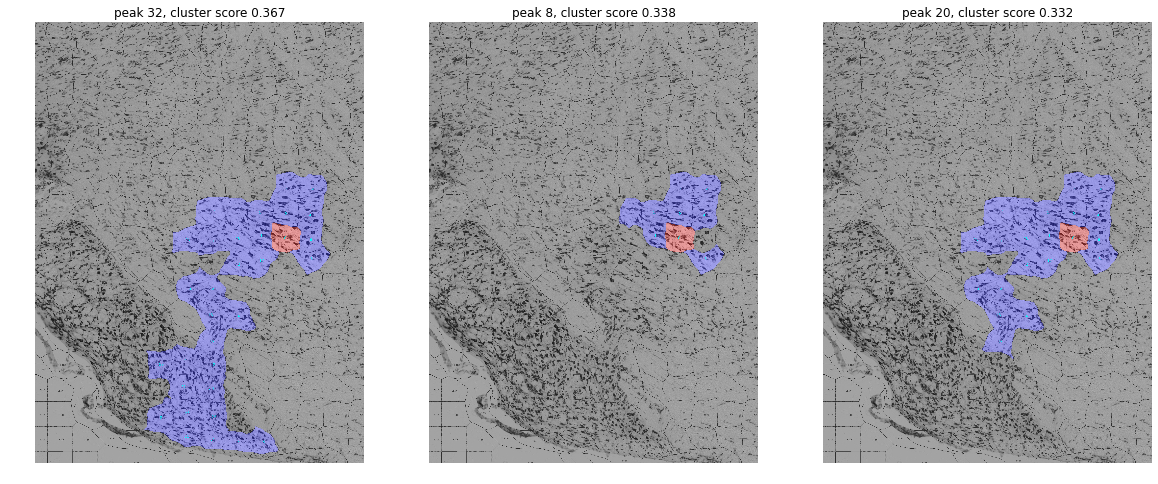

In [56]:
dm = DataManager(stack=stack_name, section=98, segm_params_id='tSLIC200')
dm.load_multiple_results(results=['texHist', 'segmentation', 'texMap', 'neighbors', 
                                  'edgeCoords', 'spCentroids', 'edgeNeighbors', 'dedgeNeighbors',
                                  'spCoords'])

clusters_allhistory, score_tuples, peaks_sorted, \
_, _ = dm.grow_cluster(730,
                                                         verbose=False, all_history=True, 
                                                         coherence_limit=0.07,
                                                         num_sp_percentage_limit=0.05,
                                                         min_size=1, min_distance=3, thresh=.4)

dm.plot_scores(peaks_sorted, clusters_allhistory, score_tuples, visualize_peaks=True, ncol=4,
              xmin=0 + dm.xmin,
              ymin=1064 + dm.ymin,
              xmax=2624 + dm.xmin, 
               ymax=4590 + dm.ymin
              )

In [2]:
def fit_ellipse_to_points(pts):
    
    pts = np.array(list(pts) if isinstance(pts, set) else pts)
    
    c0 = pts.mean(axis=0)
    
    coords0 = pts - c0

    U,S,V = np.linalg.svd(np.dot(coords0.T, coords0)/coords0.shape[0])
    v1 = U[:,0]
    v2 = U[:,1]
    s1 = np.sqrt(S[0])
    s2 = np.sqrt(S[1])
    
    return v1, v2, s1, s2, c0

In [33]:
def scores_to_vote(scores):
    vals = np.unique(scores)
    d = dict(zip(vals, np.linspace(0, 1, len(vals))))
    votes = np.array([d[s] for s in scores])
    votes = votes/votes.sum()
    return votes

def joint_rank(score_lists):
    
    ds = [scores_to_vote(ls) for ls in score_lists]
    group_indices_ranked = np.argsort(np.sum(ds, axis=0))[::-1]  
    
#     d1 = scores_to_vote(s1)
#     d2 = scores_to_vote(s2)
#     group_indices_ranked = np.argsort(d1 + d2)[::-1]
    # hight to low
    return group_indices_ranked

In [8]:
def choose_seeds(seed1, dms):
    
    dm1 = dms[0]
    seeds = [seed1]
    
    for dm in dms[1:]:
        candidate_sps = np.where((dm.sp_centroids[:,0] > dm1.sp_centroids[seed1, 0] - 1000) & \
            (dm.sp_centroids[:,0] < dm1.sp_centroids[seed1, 0] + 1000) & \
            (dm.sp_centroids[:,1] > dm1.sp_centroids[seed1, 1] - 1000) & \
            (dm.sp_centroids[:,1] < dm1.sp_centroids[seed1, 1] + 1000))[0]

        c = candidate_sps[np.argsort(chi2s([dm1.texton_hists[seed1]], dm.texton_hists[candidate_sps]))][0]
        seeds.append(c)
        
    return seeds

In [48]:
def joint_grow_region(dms, seeds, visualize_result=False, verbose=False):
    
    coords_dms = []
    npeaks_dms = []
    peaks_dms = []
    ellipse_dms = []
    clusters_dms = []

    for i, (dm, seed) in enumerate(zip(dms, seeds)):
        cluster_history, score_tuples, peaks, _, _ = dm.grow_cluster(seed, verbose=False, all_history=True, 
                                                                     coherence_limit=0.07,
                                                                     num_sp_percentage_limit=0.05,
                                                                     min_size=1, min_distance=3, thresh=.4)

        npeaks = len(peaks)
        npeaks_dms.append(npeaks)
        peaks_dms.append(peaks)

        coords = [set([tuple(p) for p in np.vstack(dm.sp_coords[cluster_history[pk]])]) for pk in peaks]

        coords_dms.append(coords)
        
        clusters = [cluster_history[pk] for pk in peaks]
        clusters_dms.append(clusters)

        ellipse = [fit_ellipse_to_points(c) for c in coords]
        ellipse_dms.append(ellipse)
                
    D1 = []
    D2 = []
    D3 = []
    
    for indices in product(*[range(npeaks) for npeaks in npeaks_dms]):
        ellipses = [ellipse_dms[i][j] for i,j in enumerate(indices)]
        v1s = [e[0] for e in ellipses]
        s1s = [e[2] for e in ellipses]
        centers = [e[4] for e in ellipses]
        
        e = pdist(v1s, metric = lambda x, y: np.abs(np.dot(x,y)))
        D1.append(e.min())

        e = np.max(s1s) - np.min(s1s)
        D2.append(-e)
        
        e = pdist(centers, 'euclidean').max()
        D3.append(-e)

    ranked_indices = joint_rank([D1, D2, D3])

    D1 = np.reshape(D1, npeaks_dms)
    D2 = np.reshape(D2, npeaks_dms)
    D3 = np.reshape(D3, npeaks_dms)
    
    pss = np.unravel_index(ranked_indices, npeaks_dms)
    a = [peaks[ps].tolist() for peaks, ps in zip(peaks_dms, pss)] + [[D1[tuple(ps)] for ps in np.c_[pss]]] +\
        [[D2[tuple(ps)] for ps in np.c_[pss]]] + [[D3[tuple(ps)] for ps in np.c_[pss]]]

    tuples = zip(*a)
    
    consensus_peak_indices = zip(*pss)[0]

    if verbose:
        for t in tuples[:5]:
            print t
    
    consensus_peaks = tuples[0][:len(seeds)]
    
    final_clusters = [cls[pk] for i, (dm, pk, cls) in enumerate(zip(dms, consensus_peak_indices, clusters_dms))]
    
    margin = 300
    
    if visualize_result:
        fig, axes = plt.subplots(int((len(seeds)-1)/3)+1, 3, figsize=(20,20), squeeze=False)

        for i, (dm, pki, pk, cls) in enumerate(zip(dms, consensus_peak_indices, consensus_peaks, clusters_dms)):
            
            centroids = dm.sp_centroids[cls[pki], ::-1]

            xmin = int(max(0, centroids[:,0].min(axis=0) - margin))
            xmax = int(max(0, centroids[:,0].max(axis=0) + margin))
            ymin = int(min(dm.image_width, centroids[:,1].min(axis=0) - margin))
            ymax = int(min(dm.image_height, centroids[:,1].max(axis=0) + margin))
                
            viz = dm.visualize_cluster(cls[pki], highlight_seed=True, seq_text=True, 
                                       xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax)
            ax = axes[i/3, i%3]
            ax.imshow(viz)
            ax.axis('off')
            ax.set_title('section %d, peak %d'%(dm.slice_ind, pk))
            
    return final_clusters


In [22]:
dms = []
stack_name = 'MD593'

for section_id in range(98, 101):
    dm = DataManager(stack=stack_name, section=section_id, segm_params_id='tSLIC200')
    dm.load_multiple_results(results=['texHist', 'segmentation', 'texMap', 'neighbors', 
                                      'edgeCoords', 'spCentroids', 'edgeNeighbors', 'dedgeNeighbors',
                                      'spCoords'])
    dms.append(dm)

In [57]:
seeds = choose_seeds(1065, dms)
print seeds

[1065, 964, 932]


(30, 21, 27, 0.9586470602596735, -163.0509313686668, -202.66594486434647)
(30, 31, 27, 0.9586470602596735, -119.24808416272623, -218.54360769177114)
(8, 21, 15, 0.72960535532902249, -160.96120306585863, -159.78186952843475)
(8, 21, 27, 0.72960535532902249, -204.76405027179919, -109.75712814924601)
(30, 21, 15, 0.91106634162577804, -220.84571020474641, -244.89459663820088)


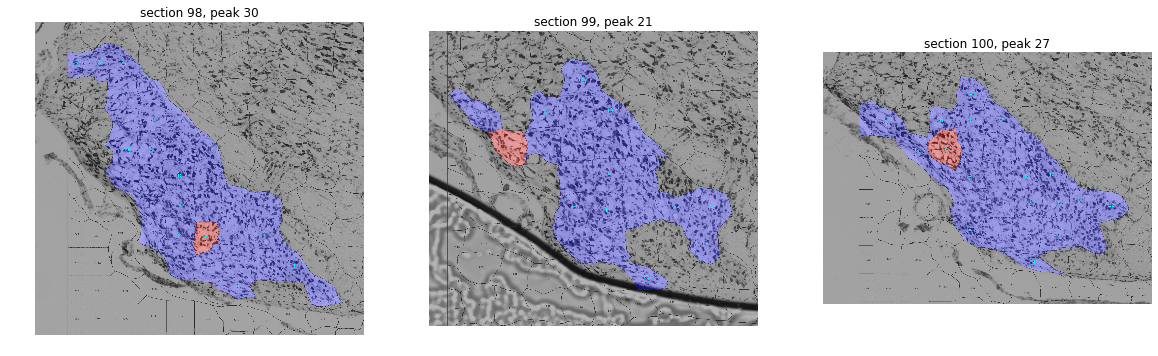

In [58]:
final_clusters = joint_grow_region(dms, seeds, visualize_result=True, verbose=True)

In [ ]:
# from shape_matching import *
# d1 = dm.convert_cluster_to_descriptor(clusters_allhistory[20])
# d2 = dm2.convert_cluster_to_descriptor(clusters_allhistory2[19])
# descriptor1 = compute_shape_context_descriptors(d1[3], dist_limit=.8)
# descriptor2 = compute_shape_context_descriptors(d2[3], dist_limit=.8)
# descriptor_dists = cdist(descriptor1, descriptor2, metric='euclidean')
# ransac_compute_rigid_transform(descriptor_dists, d1[3], d2[3], confidence_thresh=.01, 
#                                ransac_iters=50, sample_size=5,
#                                matching_iter=10, n_neighbors=10, verbose=True)